## Build a `Langgraph` with `llm`, `tool calling` and `binding`

In [1]:
pip install typing

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26396 sha256=a698a601030669c8da6356d8be007c5bad5cc863af025a1ac65ee38d76fd8d73
  Stored in directory: /home/sdevlin/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing
Note: you may need to restart the kernel to use updated packages.


In [5]:
from typing import TypedDict, Annotated, Any
from dotenv import load_dotenv
import os

print("Loading environment variables...")
load_dotenv()
print(f"Tavily API key loaded: {os.getenv('TAVILY_API_KEY')[:10]}..." if os.getenv('TAVILY_API_KEY') else "NOT FOUND")

print("Importing langchain modules...")
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
print("Langchain core imported")

print("Importing Tavily...")
from langchain_tavily import TavilySearch
print("Tavily imported")

print("Importing langgraph...")
from langgraph.graph import START, END, StateGraph, add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
print("Langgraph imported")

print("Importing IPython...")
from IPython.display import display, Image
print("All imports complete!")

Loading environment variables...
Tavily API key loaded: tvly-dev-p...
Importing langchain modules...
Langchain core imported
Importing Tavily...
Tavily imported
Importing langgraph...
Langgraph imported
Importing IPython...
All imports complete!


In [3]:
load_dotenv()

True

#### Model

In [6]:
llm = ChatOpenAI(
    model="/gpfs/projects/bsc02/llm_models/huggingface_models/Qwen3-32B",
    openai_api_key="dummy",  # vLLM doesn't need a real key
    openai_api_base="http://localhost:8002/v1",  # Your forwarded port
    temperature=0.7,
    max_tokens=500
)

#### State

In [7]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

#### Tools

In [8]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def sub(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b

def div(a: int, b: int) -> int:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a // b


In [15]:
'''
It wraps your base LLM (ChatOpenAI in this case) and gives it structured awareness of the tools (functions) you provide — so the model can:
1) Know which tools exist (name, docstring, parameters)
2) Know how to call them using structured JSON arguments
3) Produce tool call requests instead of just text
Important: It Does Not Execute the Tool
'''
llm_with_tools = llm.bind_tools([multiply, add, sub, div], tool_choice="none")

In [16]:
'''
When you call llm_with_tools.invoke(...), the LLM decides whether to call a tool or not — but it does not automatically execute the tool.
'''
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [17]:
# Use built-in ToolNode to handle execution of the tool calls
'''
ToolNode is a prebuilt LangGraph component that automatically:
1) Listens for tool call requests emitted by your LLM
2) Executes those tool functions with the provided arguments
3) Returns the results back to the graph as messages
'''
tool_node = ToolNode(tools=[multiply, add, sub, div])

#### Build graph

In [18]:
graph = StateGraph(MessagesState)
graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", tool_node)

graph.add_edge(START, "tool_calling_llm")
graph.add_edge("tool_calling_llm", "tools")
graph.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
graph.add_edge("tools", END)
app = graph.compile()

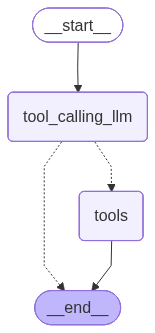

In [19]:
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
result1 = app.invoke({"messages": HumanMessage(content="multiply 8 and 2")})

In [21]:
for m in result1['messages']:
    m.pretty_print()

================================ Human Message =================================

multiply 8 and 2
================================== Ai Message ==================================

<think>
Okay, the user wants to multiply 8 and 2. Let me check the available functions. There's a multiply function that takes two integers, a and b. The parameters are required, so I need to make sure both are included. The arguments should be in a JSON object with keys "a" and "b". So, the correct call would be to use the multiply function with a=8 and b=2. I don't see any other functions needed here. Let me structure the tool_call accordingly.
</think>

<tool_call>
{"name": "multiply", "arguments": {"a": 8, "b": 2}}
</tool_call>


In [22]:
result2 = app.invoke({"messages": HumanMessage(content="what is the total population of India?")})

for m in result2['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the total population of India?
================================== Ai Message ==================================

<think>
Okay, the user is asking for the total population of India. Let me check the tools provided. The available functions are multiply, add, subtract, and divide. None of these functions can retrieve real-time data like population figures. They're all basic arithmetic operations. Since the population of India is a factual number that isn't calculated through these operations, I can't use any of the provided tools to answer this. I should inform the user that I don't have access to current population data and suggest they check a reliable source or provide a general estimate based on known information.
</think>

The functions available (multiply, add, subtract, divide) are basic arithmetic operations and cannot retrieve real-time or factual data like population figures. I don’t have a